In [1]:
import gym
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

import baselines.common.tf_util as U

from baselines import logger
from baselines import deepq
from baselines.deepq.replay_buffer import PrioritizedReplayBuffer,ReplayBuffer
from baselines.common.schedules import LinearSchedule
from baselines.deepq.models import cnn_to_mlp

In [2]:
import scipy.misc as scimisc
import gym_minecraft
from MinecraftGym import MinecraftWrapper

In [3]:
from keras import backend as K
from keras.models import Sequential,model_from_json
from keras.layers import Dense, Activation,GRU,Input,LSTM,Conv2D,Flatten
from keras.optimizers import RMSprop,Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [4]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.driving import linear
from bokeh.layouts import row,gridplot
from IPython.display import clear_output,display
output_notebook()

Loading BokehJS ...

In [5]:
from bokeh.client import push_session
from bokeh.driving import cosine
from bokeh.plotting import figure, curdoc

In [6]:
from hyperdash import Experiment

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
pre_env = gym.make("MinecraftCliffWalking1-v0")
pre_env.init(videoResolution=[400,400],allowContinuousMovement=["move", "turn", "strafe"],observeGrid=[20,-1,20,20,-1,20],observeDistance=[4,45,12])
env = MinecraftWrapper(pre_env,1/10,(41,41))

In [ ]:
def proc2_reward(info):
    if info is None:
        return 0
    elif 'observation' not in info.keys():
        return 0
    elif info['observation'] is None:
        return 0
    elif 'distanceFromdist' in info['observation'].keys():
        return 10/(0.001 + info['observation']['distanceFromdist'])
    else:
        return 0

In [ ]:
def model(inpt, num_actions, scope, reuse=False):
    """This model takes as input an observation and returns values of all actions."""
    with tf.variable_scope(scope, reuse=reuse):
        
        model = Sequential()
        model.add(Conv2D(32,(8,8),input_shape=env.observation_space.shape,activation='relu'))
        model.add(Conv2D(64,(4,4),activation='relu'))
        model.add(Conv2D(64,(3,3),activation='relu'))
        model.add(Flatten())
        model.add(Dense(256,activation='relu')
        model.add(Dense(output_dim=num_actions,activation='softmax'))
        
        
        '''
        a = Conv2D(32,(8,8),input_shape=env.observation_space.shape,activation='relu')(inpt)
        b = Conv2D(64,(3,3),activation='relu')(a)
        d = Flatten()(b)
        c = Dense(output_dim=num_actions,activation='softmax')(d)
        '''
        return model(inpt)

In [ ]:
def old_model(inpt, num_actions, scope, reuse=False):
    """This model takes as input an observation and returns values of all actions."""
    with tf.variable_scope(scope, reuse=reuse):
        out = inpt

        out =  tf.layers.conv2d(
                inputs=out,
                filters=32,
                kernel_size=[8, 8],
                padding="same",
                activation=tf.nn.relu)
        out =  tf.layers.conv2d(
                inputs=out,
                filters=64,
                kernel_size=[4, 4],
                padding="same",
                activation=tf.nn.relu)
        out2 = tf.contrib.layers.flatten(out)
        out2 = tf.layers.dense(inputs=out2, units=64)
        out2 = tf.layers.dense(inputs=out2, units=num_actions)
    return out2

In [7]:
def lib_model(inpt,num_action,scope,reuse = False):
    with tf.variable_scope(scope,reuse = reuse):
        return cnn_to_mlp([(32,8,4),(64,4,2),(64,3,1)],[256],True,True)

In [ ]:
U.reset()
exp  = Experiment("openAI DQN - Minecraft")
exp.param("notes","using MLP CNN 32,8x8,s4 - 64,4x4,s2 - 64,3x3,s1")
#env = gym.make('SpaceInvaders-v0')

with U.make_session(2) as sess:
    # Create all the functions necessary to train the model
    K.set_session(sess)
    dqn_model = cnn_to_mlp(
        convs=[(32, 8, 4), (64, 4, 2), (64, 3, 1)],
        hiddens=[256],
        dueling=True
    )
    act, train, update_target, debug = deepq.build_train(
        make_obs_ph=lambda name: U.BatchInput(env.observation_space.shape, name=name),
        q_func= model,
        num_actions=env.action_space.n,
        optimizer=tf.train.AdamOptimizer(learning_rate=5e-4),
    )
    
    # Create the replay buffer
    replay_buffer = ReplayBuffer(1000000)
    # Create the schedule for exploration starting from 1 (every action is random) down to
    # 0.02 (98% of actions are selected according to values predicted by the model).
    exploration = LinearSchedule(schedule_timesteps=1000, initial_p=1.0, final_p=0.02)

    # Initialize the parameters and copy them to the target network.
    U.initialize()
    update_target()

    episode_rewards = [0.0]
    obs = env.reset()
    for t in itertools.count():
        # Take action and update exploration to the newest value
        action = act(obs[None], update_eps=exploration.value(t))[0]
        new_obs, rew, done, info = env.step(action)
        #rew += proc2_reward(info)
        # Store transition in the replay buffer.
        replay_buffer.add(obs, action, rew, new_obs, float(done))
        obs = new_obs

        episode_rewards[-1] += rew
        if done:
            obs = env.reset()
            exp.metric("reward",episode_rewards[-1])
            episode_rewards.append(0)

        is_solved = t > 100 and np.mean(episode_rewards[-101:-1]) >= 200
        if is_solved:
            # Show off the result
            #env.render()
            #print("Solved")
            pass
        else:
            # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
            if t > 100:
                obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(32)
                train(obses_t, actions, rewards, obses_tp1, dones, np.ones_like(rewards))
            # Update target network periodically.
            if t % 1000 == 0:
                update_target()

        if done and len(episode_rewards) % 10 == 0:
            logger.record_tabular("steps", t)
            logger.record_tabular("episodes", len(episode_rewards))
            logger.record_tabular("mean episode reward", round(np.mean(episode_rewards[-101:-1]), 1))
            logger.record_tabular("% time spent exploring", int(100 * exploration.value(t)))
            logger.dump_tabular()

In [ ]:
def preprocess(rgb_array,scale = 1/12):
    frame_shape = rgb_array.shape
    
    frame = np.array(rgb_array)
    gray_frame = np.dot(frame[...,:3],[0.299,0.587,0.114]).reshape((frame_shape[0],frame_shape[1]))
    smaller = scimisc.imresize(gray_frame,scale,mode='L').astype('float64')
    smaller /= 255.0
    smaller = np.expand_dims(smaller,2) # convert to a 3D array of shape (height,width,grayscale)
    #smaller = np.reshape(smaller, [1, *(smaller.shape)])
    return smaller.astype("uint8")

In [8]:
def train(env,exp,model,buffer_size,epsilon,learning_rate,preprocessor = None):
    U.reset()
    #exp.param("notes","using MLP CNN 32,8x8,s4 - 64,4x4,s2 - 64,3x3,s1")
    

    with U.make_session(2) as sess:
        K.set_session(sess)
        try:
            # Create all the functions necessary to train the model
            
            act, train, update_target, debug = deepq.build_train(
                make_obs_ph=lambda name: U.BatchInput(env.observation_space.shape, name=name),
                q_func= model,
                num_actions=env.action_space.n,
                optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
            )
    
            # Create the replay buffer
            replay_buffer = ReplayBuffer(buffer_size)
            # Create the schedule for exploration starting from 1 (every action is random) down to
            # 0.02 (98% of actions are selected according to values predicted by the model).
            exploration = LinearSchedule(schedule_timesteps=1000, initial_p=1.0, final_p=0.02)

            # Initialize the parameters and copy them to the target network.
            U.initialize()
            update_target()
            
            #

            episode_rewards = [0.0]
            obs = env.reset()
            if preprocessor:
                obs = preprocessor(obs)
            for t in itertools.count():
                # Take action and update exploration to the newest value
                action = act(obs[None], update_eps=exploration.value(t))[0]
                new_obs, rew, done, info = env.step(action)
                if preprocessor:
                    new_obs = preprocessor(new_obs)
                #rew += proc2_reward(info)
                # Store transition in the replay buffer.
                replay_buffer.add(obs, action, rew, new_obs, float(done))
                obs = new_obs

                episode_rewards[-1] += rew
                if done:
                    obs = env.reset()
                    if preprocessor:
                        obs = preprocessor(obs)
                    if exp:
                        exp.metric("reward",episode_rewards[-1])
                    episode_rewards.append(0)
                    
                # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
                if t > 100:
                    obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(32)
                    train(obses_t, actions, rewards, obses_tp1, dones, np.ones_like(rewards))
                # Update target network periodically.
                if t % 1000 == 0:
                    update_target()

                if done and len(episode_rewards) % 10 == 0:
                    logger.record_tabular("steps", t)
                    logger.record_tabular("episodes", len(episode_rewards))
                    logger.record_tabular("mean episode reward", round(np.mean(episode_rewards[-101:-1]), 1))
                    logger.record_tabular("% time spent exploring", int(100 * exploration.value(t)))
                    logger.dump_tabular()
        except:
            if exp:
                exp.end()
            raise

In [ ]:
env = gym.make('SpaceInvaders-v0')
exp = Experiment("OpenAI - DQN - SpaceInvaders")
train(env,exp,(42,32,1),5000)

In [ ]:
pre_env = gym.make("MinecraftCliffWalking1-v0")
pre_env.init(videoResolution=[400,400],allowContinuousMovement=["move", "turn", "strafe"],observeGrid=[20,-1,20,20,-1,20],observeDistance=[4,45,12])
env = MinecraftWrapper(pre_env,1/10,(41,41))

exp = Experiment("OpenAI - DQN - SpaceInvaders")
learning_rate = 0.001
epsilon = 0.99
buffer_size = 1000000
exp.param("learning rate", "Adam Optimizer with lr = {}".format(learning_rate))
exp.param("buffer_size",buffer_size)

train(env,exp,env.observation_space.shape,5000,buffer_size,epsilon,learning_rate)



In [ ]:
pre_env = gym.make("MinecraftCliffWalking1-v0")
pre_env.init(videoResolution=[400,400],allowContinuousMovement=["move", "turn", "strafe"],observeGrid=[20,-1,20,20,-1,20],observeDistance=[4,45,12])
env = MinecraftWrapper(pre_env,1/5,(41,41))

exp = Experiment("OpenAI - DQN - CliffWalking Unnormalized input")
exp.param("memory capacity",2000000)
model1 = cnn_to_mlp([(32,8,4),(64,4,2),(64,3,1)],[256],True,True)
train(env,exp,model1,2000000,1,0.001)

{ memory capacity: 2000000 }
Instructions for updating:
Use `argmax` instead


Agent missed 13 observation(s).


| reward: -95.243161 |
| reward: -95.281449 |
| reward: -94.303300 |
| reward: -97.161375 |
| reward: -97.161319 |
| reward: -97.158468 |
| reward: -96.195225 |
| reward: -96.222156 |
| reward: -97.158468 |
-------------------------------------
| % time spent exploring | 95       |
| episodes               | 10       |
| mean episode reward    | -96.2    |
| steps                  | 44       |
-------------------------------------
| reward: -93.392468 |
| reward: -96.220235 |
| reward: -67.036959 |
| reward: -95.286541 |
| reward: -96.221503 |


Agent missed 1 observation(s).


| reward: -94.342658 |
| reward: -90.559246 |
| reward: -95.287410 |


Agent missed 1 observation(s).


| reward: -96.207628 |
| reward: -93.398344 |
-------------------------------------
| % time spent exploring | 86       |
| episodes               | 20       |
| mean episode reward    | -93.9    |
| steps                  | 138      |
-------------------------------------
| reward: -91.481891 |
| reward: -95.282963 |


Agent missed 1 observation(s).


| reward: -94.339107 |
| reward: -94.295744 |


Agent missed 1 observation(s).


| reward: -95.241489 |
| reward: -93.351255 |
| reward: -96.208738 |
| reward: -90.506862 |
| reward: -95.287157 |
| reward: -87.674616 |
-------------------------------------
| % time spent exploring | 78       |
| episodes               | 30       |
| mean episode reward    | -93.7    |
| steps                  | 218      |
-------------------------------------
| reward: -97.161635 |
| reward: -90.525361 |
| reward: -96.194989 |
| reward: -96.229133 |
| reward: -97.163792 |
| reward: -95.251885 |
| reward: -93.348576 |
| reward: -95.241020 |
| reward: -97.158187 |
| reward: -96.213955 |
-------------------------------------
| % time spent exploring | 72       |
| episodes               | 40       |
| mean episode reward    | -94.2    |
| steps                  | 276      |
-------------------------------------
| reward: -97.157697 |
| reward: -95.242821 |
| reward: -95.284877 |
| reward: -95.266148 |
| reward: -94.284796 |
| reward: -96.216331 |
| reward: -76.859005 |
| reward: -94.3

# Tests

In [ ]:
np.ones_like((5,5,3))

In [ ]:
def reward_proc(info,grid_shape = (41,41)):
    if "grid" not in info['observation'].keys():
        return 0
    # reformat grid to a vector that only show the floor with blocks
    vec = []    
    for item in info['observation']['grid'][::-1]:
        if 'lava' in item:
            vec.append(1)
        elif 'lapis' in item:
            vec.append(2)
        else:
            vec.append(0)

     # compute reward depending on distance to target
    new_state = np.array(vec)
    tmp = np.array(vec).reshape(grid_shape)
    idx2 = np.argwhere(tmp == 2)

    size = grid_shape[0]
    idx1 = (np.ceil(size/2),np.ceil(size/2))

    a = (self._dist(idx2,idx1))
    if(a > 0):
        try:
            dist_reward = 2000/(a)
        except:
            dist_reward = 0
        return dist_reward

In [ ]:
def update(x,y,handle,plot):
    plot.data_source.data['x'] += [x]
    plot.data_source.data['y'] += [y]
    push_notebook(handle=handle)

In [ ]:
fig_test = figure(plot_width=1000, plot_height=400,title="rewards_test",
                      x_axis_label="x",
                      y_axis_label="y")
test_plot = fig_test.line([],[],color="navy",line_width=2)
# make a grid
handle_test = show(fig_test, notebook_handle=True)

In [ ]:
count = 0
for e in range(100):
    done = False
    obs = env.reset()
    #env.render()
    count = 0
    while not done:
        
        #env.render()
        a = env.action_space.sample()
        s,r,done,info = env.step(a)
        r_ = proc2_reward(info)
        print(r_)
        r += r_
        update(count,r_,handle_test,test_plot)
        count += 1
    

In [ ]:
env.close()

In [ ]:
env.reset()
s,r,done,info = env.step(0)

In [ ]:
s,r,done,info = env.step(0)
info

In [ ]:
proc2_reward(info)

In [ ]:
            act, train, update_target, debug = deepq.build_train(
                make_obs_ph=lambda name: U.BatchInput(env.observation_space.shape, name=name),
                q_func= model,
                num_actions=env.action_space.n,
                optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
            )
    

In [ ]:
 make_obs_ph=lambda name: U.BatchInput(env.observation_space.shape, name=name)


In [ ]:
q_func= model

In [ ]:
optimizer=tf.train.AdamOptimizer(learning_rate=0.001)

In [ ]:
obs_t_input = U.ensure_tf_input(make_obs_ph("obs_t"))

In [ ]:
q_t = q_func(obs_t_input.get(), 6, scope="q_func", reuse=True)  # reuse parameters from act

In [ ]:
q_func_vars = U.scope_vars(U.absolute_scope_name("q_func"))

In [ ]:
tf.trainable_variables()

In [11]:
s = env.reset()

In [15]:
s_ = np.squeeze(s,-1)

In [16]:
s_.shape

(80, 80)

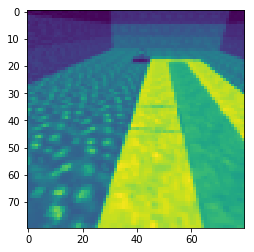

In [17]:
plt.imshow(s_)